# Evaluate likelihood ratio

In [5]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from scipy.stats import norm
from sklearn.metrics import roc_curve

from simulation.population_sim import SubhaloSimulator
from inference.estimator import ParameterizedRatioEstimator
from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Data

In [6]:
xs = np.load("../data/samples/x_test.npy")

In [7]:
idx = list(range(6))
nrows = len(idx)

In [8]:
filenames = ["carl", "alice", "alices"]
labels = ["CARL (18)", "ALICE (18)",  "ALICES (18)"]
colors = ["C0", "C1", "C2"]
ncols = 1 + len(filenames)

In [ ]:
llrs = [np.load("../data/results/llr_{}.npy".format(filename)) for filename in filenames]
grads = [np.load("../data/results/grad_x_{}.npy".format(filename)) for filename in filenames]

In [18]:
grid_res = 25

alpha_test = np.linspace(0., 20., grid_res)
beta_test = np.linspace(-1., -3., grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

## Plotting options

In [16]:
llrmin, llrmax = -10., 10.
gradmin, gradmax = 0., 1.
xmin, xmax = 0.5, 3.5

alpha_grad = 0.5

In [17]:
overlay_cmaps = []
for i, color in enumerate(colors):
    rgba = colorConverter.to_rgba(color)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('overlay_cmap_{}'.format(i),[rgba,rgba],256)
    cmap._init()
    alphas = np.linspace(0, alpha_grad, cmap.N+3)
    cmap._lut[:,-1] = alphas
    overlay_cmaps.append(cmap)

## Plot

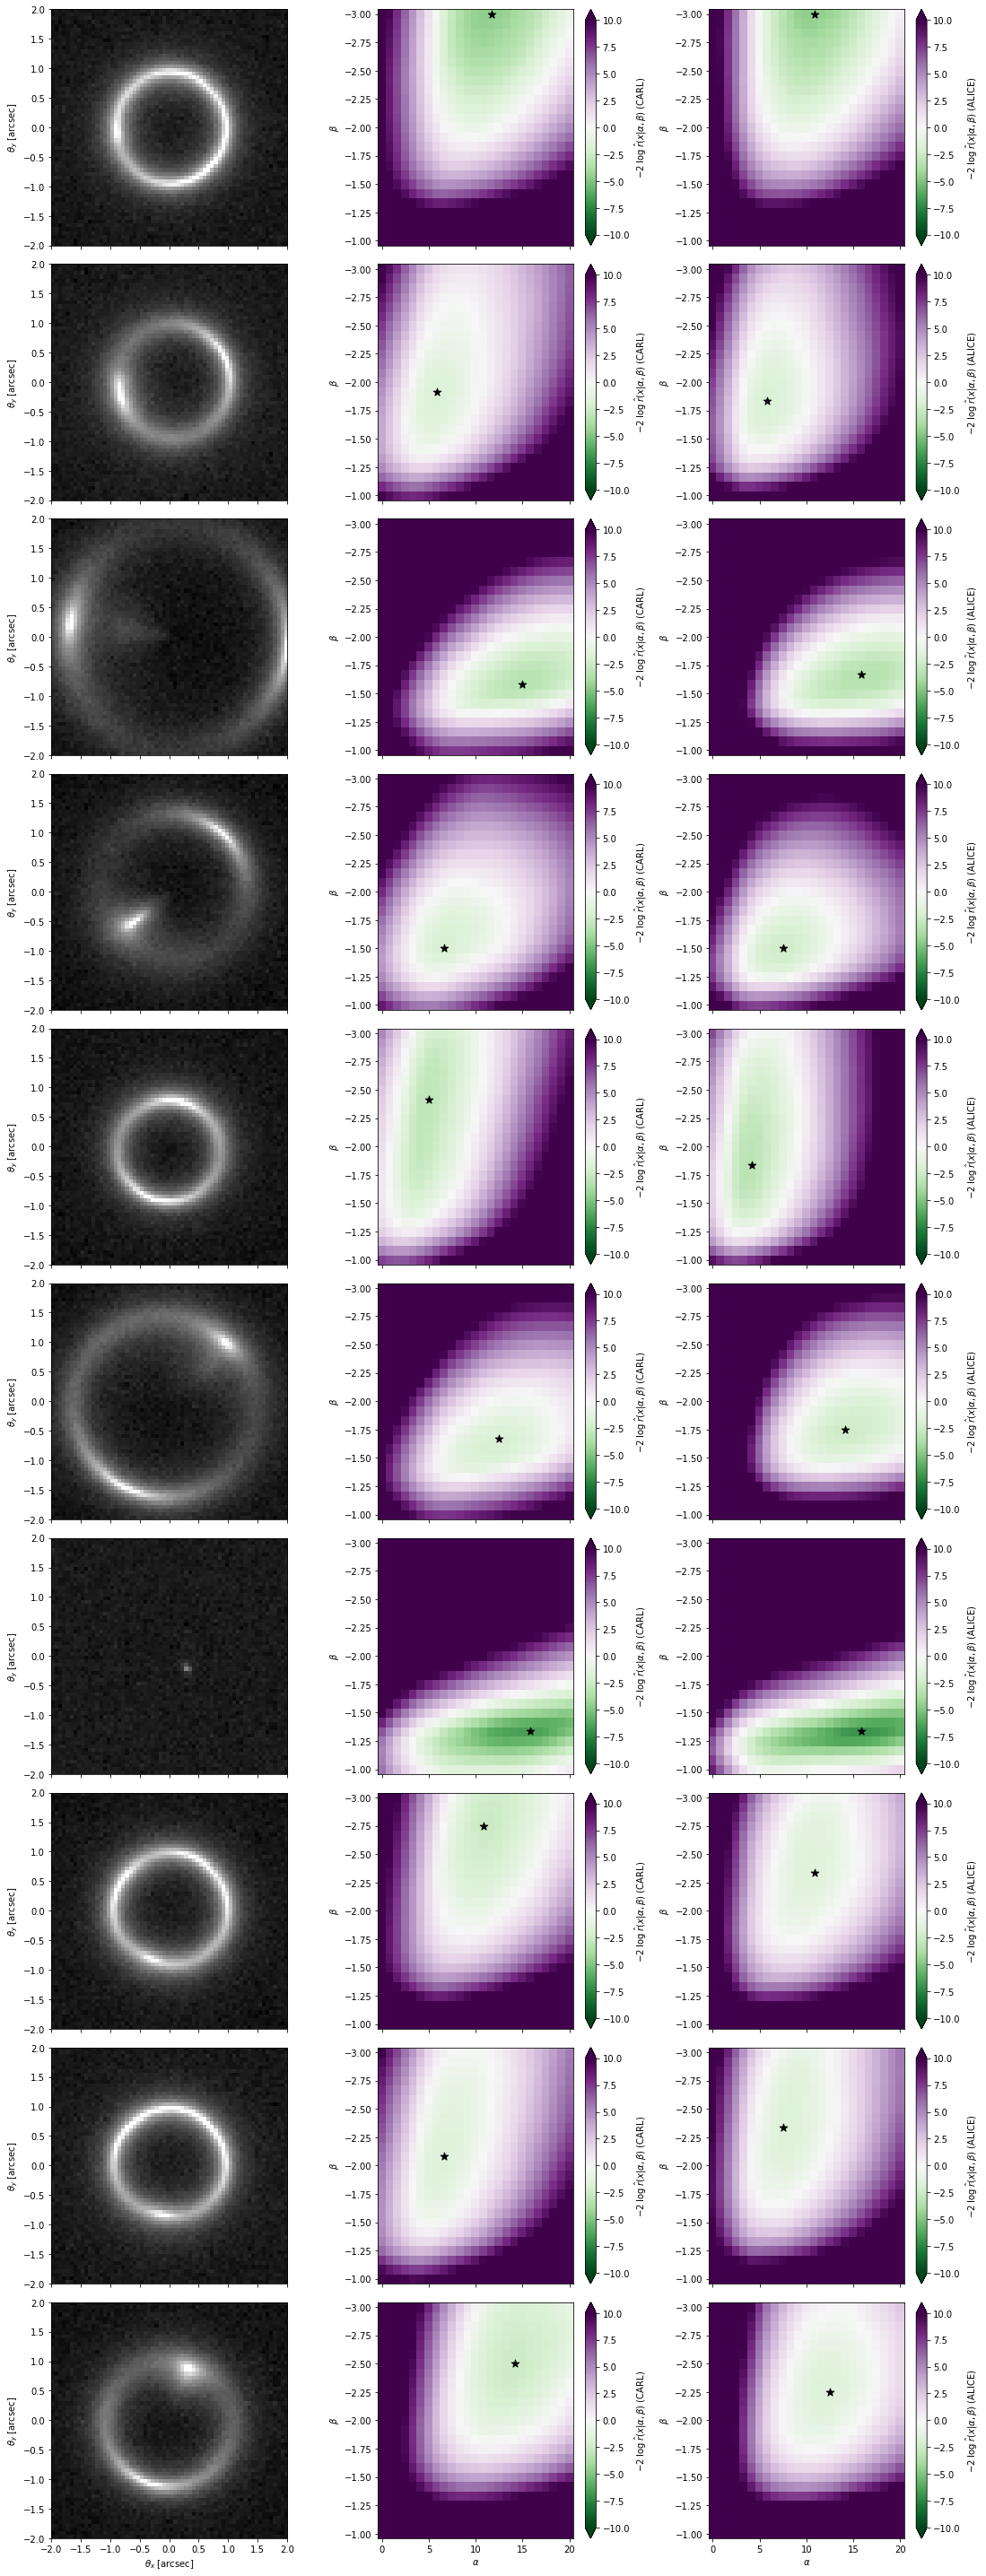

In [21]:
fig = plt.figure(figsize=(5*ncols, 4*nrows))
ax_rs = []

for i in [nrows - 1] + list(range(nrows - 1)):
    # Best fot (MLE)
    i_mles = [np.argmin(llr[:, i]) for llr in llrs]
    theta_mles = [theta_grid[i_mle] for i_mle in i_mles]
    
    
    
    # Plot image
    if i == nrows - 1:
        ax_img = plt.subplot(nrows, ncols, i*ncols+1)
        ax = ax_img
    else:
        ax = plt.subplot(10, n_col, i*n_col+1, sharex=ax_img)
    
    plt.imshow(
        np.log10(x_train[i]),
        vmin=xmin,
        vmax=xmax,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    
    for k in range(ncols - 1):
        plt.imshow(
            np.abs(grads[k][i_mles[k],i]),
            vmin=gradmin,
            vmax=gradmax,
            cmap=overlay_cmaps[k],
            extent=(-2.,2.,-2.,2.),
            origin="lower"
        )

    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    if i == nrows - 1:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    
    
    
    # Plot estimated likelihood ratios
    for k in range(ncols - 1):
        if i == nrows - 1:
            ax_rs.append(plt.subplot(nrows, ncols, i*ncols + k + 2)
            ax = ax_rs
        else:
            ax = plt.subplot(nrows, ncols, i*cols + k + 1, sharex=ax_rs[k])
        
        z = np.clip(-2. * nllrs[k][:, i], llrmin, llrmax)
    
        pcm = ax.pcolormesh(
            alpha_edges,
            beta_edges,
            z.reshape((grid_res, grid_res)),
            norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
            cmap='PRGn_r'
        )
        cbar = fig.colorbar(pcm, ax=ax, extend='both')
        plt.scatter(10., -1.9, s=60., color='black', marker='*')
        plt.scatter(theta_mles[k][0], theta_mles[k][0], s=30., color='black', marker='o')

        if i == nrows - 1:
            plt.xlabel(r'$\alpha$')
        else:
            plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.ylabel(r'$\beta$')
        cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ ' + '({})'.format(labels[k]))
        plt.xlim(alpha_edges[0], alpha_edges[-1])
        plt.ylim(beta_edges[0], beta_edges[-1])
    
                         
    
plt.tight_layout()
plt.savefig("../figures/predictions.pdf")

## Evaluate expected LLR on grid

In [24]:
grid_res = 25

alpha_test = np.linspace(0., 20., grid_res)
beta_test = np.linspace(-1., -3., grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

In [25]:
carl = ParameterizedRatioEstimator()
carl.load("../data/models/carl")

nllr_carl, _ = carl.log_likelihood_ratio(x=x_test, theta=theta_grid)
expected_nllr_carl = -2. * np.mean(nllr_carl, axis=1)

np.save("../data/results/carl_exp_nllr.npy", expected_nllr_carl)


10:16 inference.estimator  INFO    Creating model
10:16 inference.estimator  INFO      Architecture:           resnet
10:16 inference.estimator  INFO      Log input:              False
10:16 inference.estimator  INFO      Rescale input:          False
10:16 inference.estimator  INFO    Model has 11434433 trainable parameters
10:16 inference.estimator  INFO    Creating model
10:16 inference.estimator  INFO      Architecture:           resnet
10:16 inference.estimator  INFO      Log input:              False
10:16 inference.estimator  INFO      Rescale input:          True
10:16 inference.estimator  INFO    Model has 11434433 trainable parameters


In [26]:
alice = ParameterizedRatioEstimator()
alice.load("../data/models/alice")

nllr_alice, _ = alice.log_likelihood_ratio(x=x_test, theta=theta_grid)
expected_nllr_alice = -2. * np.mean(nllr_alice, axis=1)

np.save("../data/results/alice_exp_nllr.npy", expected_nllr_alice)


11:31 inference.estimator  INFO    Creating model
11:31 inference.estimator  INFO      Architecture:           resnet
11:31 inference.estimator  INFO      Log input:              False
11:31 inference.estimator  INFO      Rescale input:          False
11:31 inference.estimator  INFO    Model has 11434433 trainable parameters
11:31 inference.estimator  INFO    Creating model
11:31 inference.estimator  INFO      Architecture:           resnet
11:31 inference.estimator  INFO      Log input:              False
11:31 inference.estimator  INFO      Rescale input:          True
11:31 inference.estimator  INFO    Model has 11434433 trainable parameters


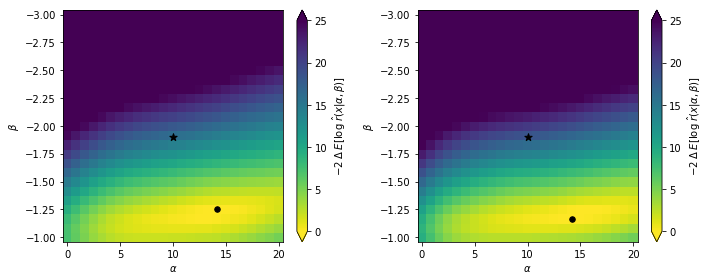

In [27]:
cmin, cmax = 0., 25.
fig = plt.figure(figsize=(10, 4))

for i_panel, (label, expected_nllr) in enumerate(
    zip(["CARL", "ALICE"], [expected_nllr_carl, expected_nllr_alice])
):
    ax = plt.subplot(1,2,i_panel+1)

    z = np.clip(expected_nllr - np.min(expected_nllr), cmin, cmax)
    z = z.reshape((grid_res, grid_res))
    best_fit = theta_grid[np.argmin(expected_nllr)]

    bin_size = alpha_test[1] - alpha_test[0]
    alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
    bin_size = beta_test[1] - beta_test[0]
    beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z,
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='viridis_r'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    plt.scatter(best_fit[0], best_fit[1], s=30., color='black', marker='o')
    plt.scatter(10., -1.9, s=60., color='black', marker='*')

    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \Delta\;E[\log \;\hat{r}(x | \alpha, \beta)]$')

plt.tight_layout()
plt.savefig("../figures/expected_llr.pdf")